In [1]:
# Import my own classes
import Prot_Post as Post
import OCTP_postprocess_CLASS as octp

import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as const
import scipy as sp
from typing import Union


from IPython.core.getipython import get_ipython

def set_plot(inline=True, tex=False) -> None:
    ipython = get_ipython()
    if inline:
        """Set the Matplotlib backend to inline for Jupyter Notebook."""
        if ipython is not None:
            ipython.run_line_magic("matplotlib", "inline")
        Post.set_plot_settings(tex=tex, svg=False)
        print("Switched to Inline Renderer")
    
    else:
        """Set the Matplotlib backend to SVG for saving high-quality images."""
        Post.set_plot_settings(tex=tex, svg=True)
        print("Switched to SVG Renderer")

In [2]:
set_plot(inline=True, tex=False)

Switched to Inline Renderer


### LOAD THE SAVED DATA MLMD
load all statepoints in our system.

In [3]:
runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]
Ts_C = np.arange(15, 66, 10, dtype=np.int32)
temps = [r"Temp_"+str(T)+"/" for T in Ts_C]
base_dir = r"MLMD/"

H2O_D_ave = np.zeros(len(Ts_C))
H2O_D_err = np.zeros_like(H2O_D_ave)
OH_D_ave = np.zeros_like(H2O_D_ave)
OH_D_err= np.zeros_like(H2O_D_ave)
K_D_ave = np.zeros_like(H2O_D_ave)
K_D_err= np.zeros_like(H2O_D_ave)
conduc_ave = np.zeros_like(H2O_D_ave)
conduc_err = np.zeros_like(H2O_D_ave)


In [4]:
for j, T_C in enumerate(Ts_C):
    posts = []
    for run in runs:
        posts.append(Post.Prot_Post(base_dir+r"Temp_"+str(T_C)+"/"+run, verbose=False))

    F_index=1
    D_OH, D_K, D_H2O, e_cond, r_bond, theta_bond = np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts))
    rdf_HOH, rdf_HH2O, rdf_HH, rdf_H2OH2O, rdf_OHH2O, rdf_KH2O = [], [], [], [], [], []
    rdf_F_HOH, rdf_F_HH2O, rdf_F_HH, rdf_F_H2OH2O, rdf_F_OHH2O, rdf_F_KH2O = [], [], [], [], [], []
    n_F_H2OH2O, n_F_OHH2O, n_F_KH2O = [], [], []
    # Preparation for postprocessing, get EoS data

    N_salt = posts[0].N_OH
    N_water = posts[0].N_H2O

    M, L, t = Post.statepoint_Gilliam(T_C, n_koh=N_salt, n_w=N_water)
    fit_vis = Post.viscosity_Guo(T_C, M)  # for finite size correct

    for i, post in enumerate(posts):
        # Structure, traditional
        # intra molecular
        rdf_HOH.append(post.rdf_HOH)
        rdf_HH2O.append(post.rdf_HH2O)
        rdf_HH.append(post.rdf_HH)
        
        
        # inter molecular
        rdf_OHH2O.append(post.rdf_OHH2O)
        rdf_KH2O.append(post.rdf_KH2O)
        rdf_H2OH2O.append(post.rdf_H2OH2O)
        rdf_r = post.rdf_r
        
        # Structure, Force
        # intra molecular
        r_bond[i], theta_bond[i] = post.water_shape()
        rdf_F_HOH.append(post.rdf_F_HOH[F_index, :])
        rdf_F_HH2O.append(post.rdf_F_HH2O[F_index, :])
        rdf_F_HH.append(post.rdf_F_HH[F_index, :])
        
        # inter molecular
        rdf_F_OHH2O.append(post.rdf_F_OHH2O[F_index, :])
        rdf_F_KH2O.append(post.rdf_F_KH2O[F_index, :])
        rdf_F_H2OH2O.append(post.rdf_F_H2OH2O[F_index, :])
        rdf_F_r = post.rdf_F_r
        
        # coordination number
        n_F_OHH2O.append(post.cordination_N('OH', 'H2O', force_rdf=True, F_idx=F_index))
        n_F_KH2O.append(post.cordination_N('K', 'H2O', force_rdf=True, F_idx=F_index))
        n_F_H2OH2O.append(post.cordination_N('H2O', 'H2O', force_rdf=True, F_idx=F_index))

        # Transport
        D_OH[i] = post.diffusion("OH", linear=False, plotting=False)
        D_K[i] = post.diffusion("K", linear=False, plotting=False)
        D_H2O[i] = post.diffusion("H2O", linear=False, plotting=False)

        # L = np.inf

        D_OH[i] = Post.fin_size_cor(D_OH[i], fit_vis, t, L)
        D_K[i] = Post.fin_size_cor(D_K[i], fit_vis, t, L)
        D_H2O[i] = Post.fin_size_cor(D_H2O[i], fit_vis, t, L)
        
        e_cond[i] = Post.electric_conductivity(D_OH[i], D_K[i], t, L, N_salt)
        
    # Structure, traditional
    # intra molecular
    rdf_HOH_ave, rdf_HOH_err = Post.averages(np.array(rdf_HOH))
    rdf_HH2O_ave, rdf_HH2O_err = Post.averages(np.array(rdf_HH2O))
    rdf_HH_ave, rdf_HH_err = Post.averages(np.array(rdf_HH))
    # inter molecular
    rdf_OHH2O_ave, rdf_OHH2O_err = Post.averages(np.array(rdf_OHH2O))
    rdf_KH2O_ave, rdf_KH2O_err = Post.averages(np.array(rdf_KH2O))
    rdf_H2OH2O_ave, rdf_H2OH2O_err = Post.averages(np.array(rdf_H2OH2O))

    # Structure, Force
    # intra molecular
    r_bond_ave, r_bond_err = Post.averages(r_bond)
    theta_bond_ave, theta_bond_err = Post.averages(theta_bond)
    rdf_F_HOH_ave, rdf_F_HOH_err = Post.averages(np.array(rdf_F_HOH))
    rdf_F_HH2O_ave, rdf_F_HH2O_err = Post.averages(np.array(rdf_F_HH2O))
    rdf_F_HH_ave, rdf_F_HH_err = Post.averages(np.array(rdf_F_HH))
    # inter molecular
    rdf_F_OHH2O_ave, rdf_F_OHH2O_err = Post.averages(np.array(rdf_F_OHH2O))
    rdf_F_KH2O_ave, rdf_F_KH2O_err = Post.averages(np.array(rdf_F_KH2O))
    rdf_F_H2OH2O_ave, rdf_F_H2OH2O_err = Post.averages(np.array(rdf_F_H2OH2O))

    n_F_OHH2O_ave, n_F_OHH2O_err = Post.averages(np.array(n_F_OHH2O))
    n_F_KH2O_ave, n_F_KH2O_err = Post.averages(np.array(n_F_KH2O))
    n_F_H2OH2O_ave, n_F_H2OH2O_err = Post.averages(np.array(n_F_H2OH2O))

    # Transport properties
    D_OH_ave, D_OH_err = Post.averages(D_OH)
    D_K_ave, D_K_err = Post.averages(D_K)
    D_H2O_ave, D_H2O_err = Post.averages(D_H2O)
    econd_ave, econd_err= Post.averages(e_cond)
    print()
    print(f'RESULTS OF: T = {T_C} C')
    print("Structure properties")
    print(f'The water bond length is ({r_bond_ave} ± {r_bond_err}) Angstrom')
    print(f'angle is ({theta_bond_ave} ± {theta_bond_err}) degree')

    print("Transport properties")
    print(f'self diffusion OH- {D_OH_ave*1e9} ± {D_OH_err*1e9} e-9 m^2/s')
    print(f'self diffusion K+ {D_K_ave*1e9} ± {D_K_err*1e9} e-9 m^2/s')
    print(f"viscosity T={t} is {fit_vis*1e3} mPa s")
    print(f'self diffusion H2O {D_H2O_ave*1e9} ± {D_H2O_err*1e9}e-9 m^2/s')
    print(f'electric conductivity {econd_ave} ± {econd_err} S/m')
    
    # print("Transport properties detailed")
    # print(f'self diffusion OH- {D_OH*1e9} e-9 m^2/s')
    # print(f'self diffusion K+ {D_K*1e9} e-9 m^2/s')
    # print(f'self diffusion H2O {D_H2O*1e9} e-9 m^2/s')
    # print(f'electric conductivity {e_cond} S/m')
    # print()
    
    H2O_D_ave[j] = D_H2O_ave*1e9
    H2O_D_err[j] = D_H2O_err*1e9
    OH_D_ave[j] = D_OH_ave*1e9
    OH_D_err[j] = D_OH_err*1e9
    K_D_ave[j] = D_K_ave*1e9
    K_D_err[j] = D_K_err*1e9
    conduc_ave[j] = econd_ave
    conduc_err[j] =econd_err


1023.2156759858243

RESULTS OF: T = 15 C
Structure properties
The water bond length is (0.9767029024658204 ± 9.731355061510588e-17) Angstrom
angle is (104.81415214176214 ± 1.2456134478733553e-14) degree
Transport properties
self diffusion OH- 3.383763274751222 ± 0.32951285762140087 e-9 m^2/s
self diffusion K+ 2.038769289771849 ± 0.11825950855858317 e-9 m^2/s
viscosity T=288.15 is 1.152146841953566 mPa s
self diffusion H2O 2.8587416903732894 ± 0.06203862981133412e-9 m^2/s
electric conductivity 10.579838934556086 ± 0.8070669797366783 S/m
1021.1365938263432

RESULTS OF: T = 25 C
Structure properties
The water bond length is (0.9773653029785158 ± 9.731355061510588e-17) Angstrom
angle is (104.46504631832475 ± 0.0) degree
Transport properties
self diffusion OH- 3.9175511483629095 ± 0.22352123980143063 e-9 m^2/s
self diffusion K+ 2.406218903939505 ± 0.10367511018265402 e-9 m^2/s
viscosity T=298.15 is 0.9328542311261425 mPa s
self diffusion H2O 3.412161037366745 ± 0.03460326206511966e-9 m^2/s


### Retrieving all CMD data

In [5]:
base_dir = 'CMD/'
groups = ['wat', 'Oh', 'K']
Ts_C = np.arange(15, 66, 10, dtype=np.int32)

runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]

CMD_H2O_D_ave = np.zeros(len(Ts_C))
CMD_H2O_D_err = np.zeros_like(H2O_D_ave)
CMD_OH_D_ave = np.zeros_like(H2O_D_ave)
CMD_OH_D_err= np.zeros_like(H2O_D_ave)
CMD_K_D_ave = np.zeros_like(H2O_D_ave)
CMD_K_D_err= np.zeros_like(H2O_D_ave)
CMD_conduc_ave = np.zeros_like(H2O_D_ave)
CMD_conduc_err = np.zeros_like(H2O_D_ave)
CMD_conduc_ons_ave = np.zeros_like(H2O_D_ave)
CMD_conduc_ons_err = np.zeros_like(H2O_D_ave)

for j, T_C in enumerate(Ts_C):
    mixture = octp.PP_OCTP(base_dir+temps[j], runs, groups, dt=1, plotting=False)
    
    # Change the file names
    mixture.filenames(Diff_Onsag='diffonsag.dat',
                      T_conduc='tconductivity.dat',
                      Diff_self='diffself.dat')
    
    mixture.changefit(Minc=12, Mmax=45)
    mixture.self_diffusivity(YH_correction=False, box_size_check=False)
    mixture.self_diffusivity(YH_correction=True, box_size_check=False)
    mixture.onsager_coeff(box_size_check=False)
    octp.cond_NE(mixture, [-1, 1], YH_correction=True)
    octp.cond_Ons(mixture, [-1, 1])

    print()
    print(f'RESULTS OF: T = {T_C} C')
    print(f"Diff K {mixture.results['Self diffusivity K/[m^2/s]'][0]*1e9} +- {mixture.results['Self diffusivity K/[m^2/s]'][1]*1e9} e-9 m^2/s")
    print(f"Diff OH {mixture.results['Self diffusivity Oh/[m^2/s]'][0]*1e9} +- {mixture.results['Self diffusivity Oh/[m^2/s]'][1]*1e9} e-9 m^2/s")
    print(f"viscosity is {mixture.results['Viscosity shear/[Pa*s]'][0]*1e3} +- {mixture.results['Viscosity shear/[Pa*s]'][1]*1e3} mPa s")
    
    CMD_H2O_D_ave[j] = mixture.results['Self diffusivity YH_cor wat/[m^2/s]'][0]*1e9
    CMD_H2O_D_err[j] = mixture.results['Self diffusivity YH_cor wat/[m^2/s]'][1]*1e9
    CMD_OH_D_ave[j] = mixture.results['Self diffusivity YH_cor Oh/[m^2/s]'][0]*1e9
    CMD_OH_D_err[j] = mixture.results['Self diffusivity YH_cor Oh/[m^2/s]'][1]*1e9
    CMD_K_D_ave[j] = mixture.results['Self diffusivity YH_cor K/[m^2/s]'][0]*1e9
    CMD_K_D_err[j] = mixture.results['Self diffusivity YH_cor K/[m^2/s]'][1]*1e9
    
    CMD_conduc_ave[j] = mixture.results['E conduct NEYH_cor /[S/m]'][0]
    CMD_conduc_err[j] = mixture.results['E conduct NEYH_cor /[S/m]'][1]
    CMD_conduc_ons_ave[j] = mixture.results['E conduct Ons/[S/m]'][0]
    CMD_conduc_ons_err[j] = mixture.results['E conduct Ons/[S/m]'][1]

    print(f"Diff K YH {CMD_K_D_ave[j]} +- {CMD_K_D_err[j]} e-9 m^2/s")
    print(f"Diff OH YH {CMD_OH_D_ave[j]} +- {CMD_OH_D_err[j]} e-9 m^2/s")
    print(f"conductivty NE {CMD_conduc_ave[j]} +- {CMD_conduc_err[j]} S/m")

    


RESULTS OF: T = 15 C
Diff K 1.4380285635562455 +- 0.043946871880831684 e-9 m^2/s
Diff OH 0.7739432882177454 +- 0.01606999895057142 e-9 m^2/s
viscosity is 1.0981834047510457 +- 0.03266855216328575 mPa s
Diff K YH 1.6094125962837487 +- 0.04543193001928747 e-9 m^2/s
Diff OH YH 0.9456159387854842 +- 0.020075132527071538 e-9 m^2/s
conductivty NE 4.992471991514614 +- 0.09708095310175441 S/m

RESULTS OF: T = 25 C
Diff K 1.7916252252862952 +- 0.03787685201429972 e-9 m^2/s
Diff OH 1.0063495019123638 +- 0.02654013731979826 e-9 m^2/s
viscosity is 0.8664451921818481 +- 0.024388883921113626 mPa s
Diff K YH 2.014506037749502 +- 0.04260793755109862 e-9 m^2/s
Diff OH YH 1.2292303143755707 +- 0.030181628359374216 e-9 m^2/s
conductivty NE 6.109587371904296 +- 0.09841397555408642 S/m

RESULTS OF: T = 35 C
Diff K 2.1712534476692755 +- 0.06720275390920294 e-9 m^2/s
Diff OH 1.2815250885217495 +- 0.03566743484549687 e-9 m^2/s
viscosity is 0.7324676673876337 +- 0.015354259565905014 mPa s
Diff K YH 2.44331727

### Experimental fit curve

In [6]:
fit_T = np.linspace(min(Ts_C)-2, max(Ts_C)+2, 250)
fit_econd = Post.conductivity_Gilliam(fit_T, M)

### Plot figure 3

Text(0, 0.5, 'sigma/[S/m]')

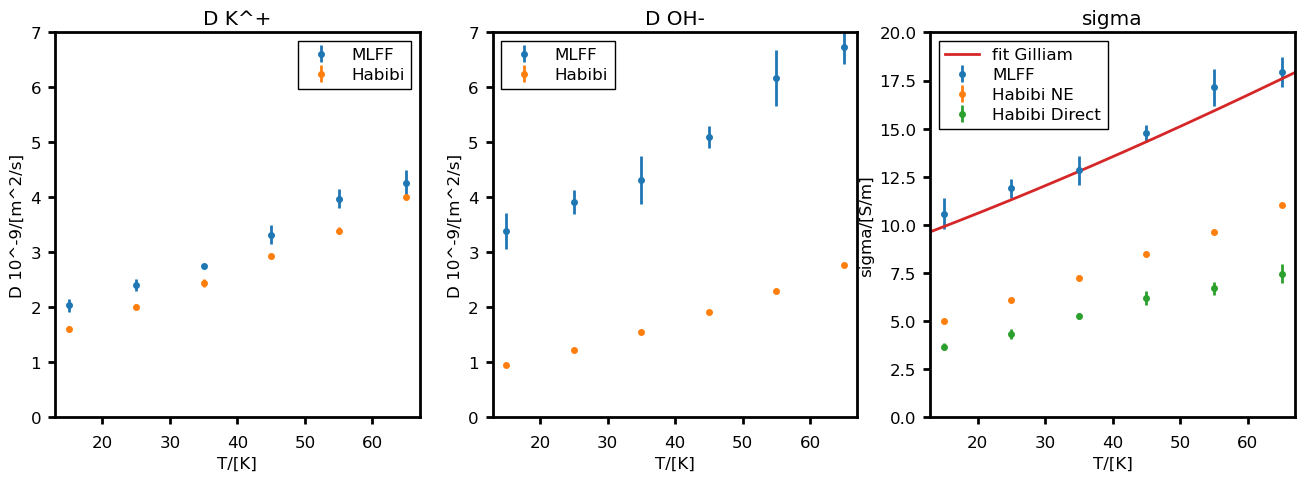

In [7]:
# Create a 2x2 subplot figure with fixed aspect ratios
fig, axs = plt.subplots(1, 3)

# # Top-left subplot with placeholder data
# axs[0].errorbar(Ts_C, H2O_D_ave, yerr=H2O_D_err, fmt='o', markersize='3', label='MLFF')
# axs[0].errorbar(Ts_C, CMD_H2O_D_ave, yerr=CMD_H2O_D_err, fmt='o', markersize='3', label='Habibi')
# axs[0].set_title(r'D H_2O')
# axs[0].legend()
# axs[0].set_xlim(min(fit_T), max(fit_T))
# axs[0].set_xlabel(r'T/[\si{\kelvin}]')
# axs[0].set_ylim(0, 7)
# axs[0].set_ylabel(r'D 10^-9/[\si{\m\squared\per\s}]')


# Top-left subplot with placeholder data
axs[0].errorbar(Ts_C, K_D_ave, yerr=K_D_err, fmt='o', markersize='3', label='MLFF')
axs[0].errorbar(Ts_C, CMD_K_D_ave, yerr=CMD_K_D_err, fmt='o', markersize='3', label='Habibi')
axs[0].set_title('D K^+')
axs[0].legend()
axs[0].set_xlim(min(fit_T), max(fit_T))
axs[0].set_xlabel('T/[K]')
axs[0].set_ylim(0, 7)
axs[0].set_ylabel('D 10^-9/[m^2/s]')

# Top-left subplot with placeholder data
axs[1].errorbar(Ts_C, OH_D_ave, yerr=OH_D_err, fmt='o', markersize='3', label='MLFF')
axs[1].errorbar(Ts_C, CMD_OH_D_ave, yerr=CMD_OH_D_err, fmt='o', markersize='3', label='Habibi')
axs[1].set_title('D OH-')
axs[1].legend()
axs[1].set_xlim(min(fit_T), max(fit_T))
axs[1].set_xlabel('T/[K]')
axs[1].set_ylim(0, 7) 
axs[1].set_ylabel('D 10^-9/[m^2/s]')


# Top-left subplot with placeholder data
axs[2].errorbar(Ts_C, conduc_ave, yerr=conduc_err, fmt='o', markersize='3', label='MLFF')
axs[2].errorbar(Ts_C, CMD_conduc_ave, yerr=CMD_conduc_err, fmt='o', markersize='3', label='Habibi NE')
axs[2].errorbar(Ts_C, CMD_conduc_ons_ave, yerr=CMD_conduc_ons_err, fmt='o', markersize='3', label='Habibi Direct')
axs[2].plot(fit_T, fit_econd, label='fit Gilliam')
axs[2].set_title('sigma')
axs[2].legend()
axs[2].set_xlim(min(fit_T), max(fit_T))
axs[2].set_xlabel('T/[K]')
axs[2].set_ylim(0, 20)
axs[2].set_ylabel('sigma/[S/m]')

# Adjust layout to maintain aspect ratio
# fig.tight_layout()
# plt.show()

Save the outputs in plot2/data.txt format so we can use it in latex.

In [8]:
np.savetxt('plot3/3a_my.txt', np.column_stack((Ts_C, K_D_ave*1e-9, K_D_err*1e-9, CMD_K_D_ave*1e-9, CMD_K_D_err*1e-9)), delimiter=' ', header="TEMP MLMD_K_m MLMD_K_e CMD_K_m CMD_K_e", comments="")
np.savetxt('plot3/3b_my.txt', np.column_stack((Ts_C, OH_D_ave*1e-9, OH_D_err*1e-9, CMD_OH_D_ave*1e-9, CMD_OH_D_err*1e-9)), delimiter=' ', header="TEMP MLMD_OH_m MLMD_OH_e CMD_OH_m CMD_OH_e", comments="")
np.savetxt('plot3/3c_my.txt', np.column_stack((Ts_C, conduc_ave, conduc_err, CMD_conduc_ave, CMD_conduc_err)), delimiter=' ', header="TEMP MLMD_sig_m MLMD_sig_e CMD_sig_m CMD_sig_e", comments="")
np.savetxt('plot3/3c_gilliam.txt', np.column_stack((fit_T, fit_econd)), delimiter=' ', header="TEMP FIT", comments="")

In [9]:
D_OH_Santiburcio = np.array([6.64, 2.12, 3.22, 3.50, 3.01, 4.72, 3.96, 4.24, 5.32, 3.89, 4.27, 3.5, 4.25])*1e-9 # m^2/s, all CP MD results
T_Santibriucio = np.array([309.8, 291.6, 301.7, 298.3, 290.2, 299.9, 298.1, 297.5, 305.8, 299.6, 300.1, 297.88, 299.3]) - const.zero_Celsius  # degreeC, all CPMD results

D_OH_Santiburcio_ave, D_OH_Santiburcio_err = Post.averages(D_OH_Santiburcio)
T_Santibriucio_ave, T_Santibriucio_err = Post.averages(T_Santibriucio)
np.savetxt('plot3/3b_santiburcio.txt', np.column_stack((T_Santibriucio_ave, T_Santibriucio_err, D_OH_Santiburcio_ave, D_OH_Santiburcio_err)), delimiter=' ', header="TEMP_m TEMP_e D_OH_m D_OH_e", comments="")


## HEAVY Water comparison (2u per hydrogen)

In [10]:
runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]
Ts_C = np.arange(15, 66, 10, dtype=np.int32)
temps = [r"Temp_"+str(T)+"/" for T in Ts_C]
base_dir = r"MLMD_heavy/"

H2O_D_ave = np.zeros(len(Ts_C))
H2O_D_err = np.zeros_like(H2O_D_ave)
OH_D_ave = np.zeros_like(H2O_D_ave)
OH_D_err= np.zeros_like(H2O_D_ave)
K_D_ave = np.zeros_like(H2O_D_ave)
K_D_err= np.zeros_like(H2O_D_ave)
conduc_ave = np.zeros_like(H2O_D_ave)
conduc_err = np.zeros_like(H2O_D_ave)

In [11]:
for j, T_C in enumerate(Ts_C):
    posts = []
    for run in runs:
        posts.append(Post.Prot_Post(base_dir+r"Temp_"+str(T_C)+"/"+run+'part_uH_2/', verbose=False))

    F_index=1
    D_OH, D_K, D_H2O, e_cond, r_bond, theta_bond = np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts))
    rdf_HOH, rdf_HH2O, rdf_HH, rdf_H2OH2O, rdf_OHH2O, rdf_KH2O = [], [], [], [], [], []
    rdf_F_HOH, rdf_F_HH2O, rdf_F_HH, rdf_F_H2OH2O, rdf_F_OHH2O, rdf_F_KH2O = [], [], [], [], [], []
    n_F_H2OH2O, n_F_OHH2O, n_F_KH2O = [], [], []
    # Preparation for postprocessing, get EoS data

    N_salt = posts[0].N_OH
    N_water = posts[0].N_H2O

    M, L, t = Post.statepoint_Gilliam(T_C, n_koh=N_salt, n_w=N_water)
    fit_vis = Post.viscosity_Guo(T_C, M)  # for finite size correct

    for i, post in enumerate(posts):
        # Structure, traditional
        # intra molecular
        rdf_HOH.append(post.rdf_HOH)
        rdf_HH2O.append(post.rdf_HH2O)
        rdf_HH.append(post.rdf_HH)
        
        # inter molecular
        rdf_OHH2O.append(post.rdf_OHH2O)
        rdf_KH2O.append(post.rdf_KH2O)
        rdf_H2OH2O.append(post.rdf_H2OH2O)
        rdf_r = post.rdf_r
        
        # Structure, Force
        # intra molecular
        r_bond[i], theta_bond[i] = post.water_shape()
        rdf_F_HOH.append(post.rdf_F_HOH[F_index, :])
        rdf_F_HH2O.append(post.rdf_F_HH2O[F_index, :])
        rdf_F_HH.append(post.rdf_F_HH[F_index, :])
        
        # inter molecular
        rdf_F_OHH2O.append(post.rdf_F_OHH2O[F_index, :])
        rdf_F_KH2O.append(post.rdf_F_KH2O[F_index, :])
        rdf_F_H2OH2O.append(post.rdf_F_H2OH2O[F_index, :])
        rdf_F_r = post.rdf_F_r
        
        # coordination number
        n_F_OHH2O.append(post.cordination_N('OH', 'H2O', force_rdf=True, F_idx=F_index))
        n_F_KH2O.append(post.cordination_N('K', 'H2O', force_rdf=True, F_idx=F_index))
        n_F_H2OH2O.append(post.cordination_N('H2O', 'H2O', force_rdf=True, F_idx=F_index))

        # Transport
        D_OH[i] = post.diffusion("OH", linear=False, plotting=False)
        D_K[i] = post.diffusion("K", linear=False, plotting=False)
        D_H2O[i] = post.diffusion("H2O", linear=False, plotting=False)

        # L = np.inf
        D_OH[i] = Post.fin_size_cor(D_OH[i], fit_vis, t, L)
        D_K[i] = Post.fin_size_cor(D_K[i], fit_vis, t, L)
        D_H2O[i] = Post.fin_size_cor(D_H2O[i], fit_vis, t, L)
        
        e_cond[i] = Post.electric_conductivity(D_OH[i], D_K[i], t, L, N_salt)
        
    # Structure, traditional
    # intra molecular
    rdf_HOH_ave, rdf_HOH_err = Post.averages(np.array(rdf_HOH))
    rdf_HH2O_ave, rdf_HH2O_err = Post.averages(np.array(rdf_HH2O))
    rdf_HH_ave, rdf_HH_err = Post.averages(np.array(rdf_HH))
    # inter molecular
    rdf_OHH2O_ave, rdf_OHH2O_err = Post.averages(np.array(rdf_OHH2O))
    rdf_KH2O_ave, rdf_KH2O_err = Post.averages(np.array(rdf_KH2O))
    rdf_H2OH2O_ave, rdf_H2OH2O_err = Post.averages(np.array(rdf_H2OH2O))

    # Structure, Force
    # intra molecular
    r_bond_ave, r_bond_err = Post.averages(data=r_bond)
    theta_bond_ave, theta_bond_err = Post.averages(theta_bond)
    rdf_F_HOH_ave, rdf_F_HOH_err = Post.averages(np.array(rdf_F_HOH))
    rdf_F_HH2O_ave, rdf_F_HH2O_err = Post.averages(np.array(rdf_F_HH2O))
    rdf_F_HH_ave, rdf_F_HH_err = Post.averages(np.array(rdf_F_HH))
    # inter molecular
    rdf_F_OHH2O_ave, rdf_F_OHH2O_err = Post.averages(np.array(rdf_F_OHH2O))
    rdf_F_KH2O_ave, rdf_F_KH2O_err = Post.averages(np.array(rdf_F_KH2O))
    rdf_F_H2OH2O_ave, rdf_F_H2OH2O_err = Post.averages(np.array(rdf_F_H2OH2O))

    n_F_OHH2O_ave, n_F_OHH2O_err = Post.averages(np.array(n_F_OHH2O))
    n_F_KH2O_ave, n_F_KH2O_err = Post.averages(np.array(n_F_KH2O))
    n_F_H2OH2O_ave, n_F_H2OH2O_err = Post.averages(np.array(n_F_H2OH2O))

    # Transport properties
    D_OH_ave, D_OH_err = Post.averages(D_OH)
    D_K_ave, D_K_err = Post.averages(D_K)
    D_H2O_ave, D_H2O_err = Post.averages(D_H2O)
    econd_ave, econd_err= Post.averages(e_cond)
    # print()
    # print(f'RESULTS OF: T = {T_C} C')
    # print("Structure properties")
    # print(f'The water bond length is ({r_bond_ave} ± {r_bond_err}) Angstrom')
    # print(f'angle is ({theta_bond_ave} ± {theta_bond_err}) degree')

    print("Transport properties")
    print(f'self diffusion OH- {D_OH_ave*1e9} ± {D_OH_err*1e9} e-9 m^2/s')
    print(f'self diffusion K+ {D_K_ave*1e9} ± {D_K_err*1e9} e-9 m^2/s')
    # print(f'self diffusion H2O {D_H2O_ave*1e9} ± {D_H2O_err*1e9}e-9 m^2/s')
    print(f'electric conductivity {econd_ave} ± {econd_err} S/m')
    
    # print("Transport properties detailed")
    # print(f'self diffusion OH- {D_OH*1e9} e-9 m^2/s')
    # print(f'self diffusion K+ {D_K*1e9} e-9 m^2/s')
    # print(f'self diffusion H2O {D_H2O*1e9} e-9 m^2/s')
    # print(f'electric conductivity {e_cond} S/m')
    # print()
    
    H2O_D_ave[j] = D_H2O_ave*1e9
    H2O_D_err[j] = D_H2O_err*1e9
    OH_D_ave[j] = D_OH_ave*1e9
    OH_D_err[j] = D_OH_err*1e9
    K_D_ave[j] = D_K_ave*1e9
    K_D_err[j] = D_H2O_err*1e9
    conduc_ave[j] = econd_ave
    conduc_err[j] =econd_err


1023.2156759858243
Transport properties
self diffusion OH- 2.8039213007953587 ± 0.26974345601558336 e-9 m^2/s
self diffusion K+ 1.7905035985246134 ± 0.1308365767366496 e-9 m^2/s
electric conductivity 8.964127896573478 ± 0.7217960925032103 S/m
1021.1365938263432
Transport properties
self diffusion OH- 3.554949362193433 ± 0.14077158030780104 e-9 m^2/s
self diffusion K+ 2.1409082925455145 ± 0.15360814612447787 e-9 m^2/s
electric conductivity 10.718560899568637 ± 0.47668957312262955 S/m
1018.084542183361
Transport properties
self diffusion OH- 3.96181489355923 ± 0.3410322543636257 e-9 m^2/s
self diffusion K+ 2.56879288803732 ± 0.138163146583573 e-9 m^2/s
electric conductivity 11.855055707797048 ± 0.6787553382837659 S/m
1014.1004881930253
Transport properties
self diffusion OH- 4.6232895820372555 ± 0.44368784794407756 e-9 m^2/s
self diffusion K+ 3.1375200385713216 ± 0.10323334725666578 e-9 m^2/s
electric conductivity 13.592033002209583 ± 0.6445062477284709 S/m
1009.4916853764415
Transport p

In [12]:
np.savetxt('plot3/3a_my_h2.txt', np.column_stack((Ts_C, K_D_ave*1e-9, K_D_err*1e-9)), delimiter=' ', header="TEMP MLMD_K_m MLMD_K_e", comments="")
np.savetxt('plot3/3b_my_h2.txt', np.column_stack((Ts_C, OH_D_ave*1e-9, OH_D_err*1e-9)), delimiter=' ', header="TEMP MLMD_OH_m MLMD_OH_e", comments="")
np.savetxt('plot3/3c_my_h2.txt', np.column_stack((Ts_C, conduc_ave, conduc_err)), delimiter=' ', header="TEMP MLMD_sig_m MLMD_sig_e", comments="")

## HEAVY WATER Tritium version

In [13]:
runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]
Ts_C = np.arange(15, 66, 10, dtype=np.int32)
temps = [r"Temp_"+str(T)+"/" for T in Ts_C]
base_dir = r"MLMD_heavy/"

H2O_D_ave = np.zeros(len(Ts_C))
H2O_D_err = np.zeros_like(H2O_D_ave)
OH_D_ave = np.zeros_like(H2O_D_ave)
OH_D_err= np.zeros_like(H2O_D_ave)
K_D_ave = np.zeros_like(H2O_D_ave)
K_D_err= np.zeros_like(H2O_D_ave)
conduc_ave = np.zeros_like(H2O_D_ave)
conduc_err = np.zeros_like(H2O_D_ave)

In [14]:
for j, T_C in enumerate(Ts_C):
    posts = []
    for run in runs:
        posts.append(Post.Prot_Post(base_dir+r"Temp_"+str(T_C)+"/"+run+'part_uH_3/', verbose=False))

    F_index=1
    D_OH, D_K, D_H2O, e_cond, r_bond, theta_bond = np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts)), np.zeros(len(posts))
    rdf_HOH, rdf_HH2O, rdf_HH, rdf_H2OH2O, rdf_OHH2O, rdf_KH2O = [], [], [], [], [], []
    rdf_F_HOH, rdf_F_HH2O, rdf_F_HH, rdf_F_H2OH2O, rdf_F_OHH2O, rdf_F_KH2O = [], [], [], [], [], []
    n_F_H2OH2O, n_F_OHH2O, n_F_KH2O = [], [], []
    # Preparation for postprocessing, get EoS data

    N_salt = posts[0].N_OH
    N_water = posts[0].N_H2O

    M, L, t = Post.statepoint_Gilliam(T_C, n_koh=N_salt, n_w=N_water)
    fit_vis = Post.viscosity_Guo(T_C, M)  # for finite size correct

    for i, post in enumerate(posts):
        # Structure, traditional
        # intra molecular
        rdf_HOH.append(post.rdf_HOH)
        rdf_HH2O.append(post.rdf_HH2O)
        rdf_HH.append(post.rdf_HH)
        
        # inter molecular
        rdf_OHH2O.append(post.rdf_OHH2O)
        rdf_KH2O.append(post.rdf_KH2O)
        rdf_H2OH2O.append(post.rdf_H2OH2O)
        rdf_r = post.rdf_r
        
        # Structure, Force
        # intra molecular
        r_bond[i], theta_bond[i] = post.water_shape()
        rdf_F_HOH.append(post.rdf_F_HOH[F_index, :])
        rdf_F_HH2O.append(post.rdf_F_HH2O[F_index, :])
        rdf_F_HH.append(post.rdf_F_HH[F_index, :])
        
        # inter molecular
        rdf_F_OHH2O.append(post.rdf_F_OHH2O[F_index, :])
        rdf_F_KH2O.append(post.rdf_F_KH2O[F_index, :])
        rdf_F_H2OH2O.append(post.rdf_F_H2OH2O[F_index, :])
        rdf_F_r = post.rdf_F_r
        
        # coordination number
        n_F_OHH2O.append(post.cordination_N('OH', 'H2O', force_rdf=True, F_idx=F_index))
        n_F_KH2O.append(post.cordination_N('K', 'H2O', force_rdf=True, F_idx=F_index))
        n_F_H2OH2O.append(post.cordination_N('H2O', 'H2O', force_rdf=True, F_idx=F_index))

        # Transport
        D_OH[i] = post.diffusion("OH", linear=False, plotting=False)
        D_K[i] = post.diffusion("K", linear=False, plotting=False)
        D_H2O[i] = post.diffusion("H2O", linear=False, plotting=False)

        # L = np.inf

        D_OH[i] = Post.fin_size_cor(D_OH[i], fit_vis, t, L)
        D_K[i] = Post.fin_size_cor(D_K[i], fit_vis, t, L)
        D_H2O[i] = Post.fin_size_cor(D_H2O[i], fit_vis, t, L)
        
        e_cond[i] = Post.electric_conductivity(D_OH[i], D_K[i], t, L, N_salt)
        
    # Structure, traditional
    # intra molecular
    rdf_HOH_ave, rdf_HOH_err = Post.averages(np.array(rdf_HOH))
    rdf_HH2O_ave, rdf_HH2O_err = Post.averages(np.array(rdf_HH2O))
    rdf_HH_ave, rdf_HH_err = Post.averages(np.array(rdf_HH))
    # inter molecular
    rdf_OHH2O_ave, rdf_OHH2O_err = Post.averages(np.array(rdf_OHH2O))
    rdf_KH2O_ave, rdf_KH2O_err = Post.averages(np.array(rdf_KH2O))
    rdf_H2OH2O_ave, rdf_H2OH2O_err = Post.averages(np.array(rdf_H2OH2O))

    # Structure, Force
    # intra molecular
    r_bond_ave, r_bond_err = Post.averages(data=r_bond)
    theta_bond_ave, theta_bond_err = Post.averages(theta_bond)
    rdf_F_HOH_ave, rdf_F_HOH_err = Post.averages(np.array(rdf_F_HOH))
    rdf_F_HH2O_ave, rdf_F_HH2O_err = Post.averages(np.array(rdf_F_HH2O))
    rdf_F_HH_ave, rdf_F_HH_err = Post.averages(np.array(rdf_F_HH))
    # inter molecular
    rdf_F_OHH2O_ave, rdf_F_OHH2O_err = Post.averages(np.array(rdf_F_OHH2O))
    rdf_F_KH2O_ave, rdf_F_KH2O_err = Post.averages(np.array(rdf_F_KH2O))
    rdf_F_H2OH2O_ave, rdf_F_H2OH2O_err = Post.averages(np.array(rdf_F_H2OH2O))

    n_F_OHH2O_ave, n_F_OHH2O_err = Post.averages(np.array(n_F_OHH2O))
    n_F_KH2O_ave, n_F_KH2O_err = Post.averages(np.array(n_F_KH2O))
    n_F_H2OH2O_ave, n_F_H2OH2O_err = Post.averages(np.array(n_F_H2OH2O))

    # Transport properties
    D_OH_ave, D_OH_err = Post.averages(D_OH)
    D_K_ave, D_K_err = Post.averages(D_K)
    D_H2O_ave, D_H2O_err = Post.averages(D_H2O)
    econd_ave, econd_err= Post.averages(e_cond)
    print()
    print(f'RESULTS OF: T = {T_C} C')
    # print("Structure properties")
    # print(f'The water bond length is ({r_bond_ave} ± {r_bond_err}) Angstrom')
    # print(f'angle is ({theta_bond_ave} ± {theta_bond_err}) degree')

    print("Transport properties")
    print(f'self diffusion K+ {D_K_ave*1e9} ± {D_K_err*1e9} e-9 m^2/s')
    print(f'self diffusion OH- {D_OH_ave*1e9} ± {D_OH_err*1e9} e-9 m^2/s')
    # print(f'self diffusion H2O {D_H2O_ave*1e9} ± {D_H2O_err*1e9}e-9 m^2/s')
    print(f'electric conductivity {econd_ave} ± {econd_err} S/m')
    
    # print("Transport properties detailed")
    # print(f'self diffusion OH- {D_OH*1e9} e-9 m^2/s')
    # print(f'self diffusion K+ {D_K*1e9} e-9 m^2/s')
    # print(f'self diffusion H2O {D_H2O*1e9} e-9 m^2/s')
    # print(f'electric conductivity {e_cond} S/m')
    # print()
    
    
    H2O_D_ave[j] = D_H2O_ave*1e9
    H2O_D_err[j] = D_H2O_err*1e9
    OH_D_ave[j] = D_OH_ave*1e9
    OH_D_err[j] = D_OH_err*1e9
    K_D_ave[j] = D_K_ave*1e9
    K_D_err[j] = D_H2O_err*1e9
    conduc_ave[j] = econd_ave
    conduc_err[j] =econd_err


1023.2156759858243

RESULTS OF: T = 15 C
Transport properties
self diffusion K+ 1.636073124726415 ± 0.05940822102968971 e-9 m^2/s
self diffusion OH- 2.6655274653658254 ± 0.19829641231111314 e-9 m^2/s
electric conductivity 8.39280186194144 ± 0.4438863116232796 S/m
1021.1365938263432

RESULTS OF: T = 25 C
Transport properties
self diffusion K+ 2.0391912838860717 ± 0.1762991843743742 e-9 m^2/s
self diffusion OH- 3.144144414133743 ± 0.2947783425481217 e-9 m^2/s
electric conductivity 9.754088446348264 ± 0.8487528910373979 S/m
1018.084542183361

RESULTS OF: T = 35 C
Transport properties
self diffusion K+ 2.3742019548362596 ± 0.12505275017507114 e-9 m^2/s
self diffusion OH- 3.953359103746654 ± 0.2756415688043662 e-9 m^2/s
electric conductivity 11.48646364207911 ± 0.5652542238219137 S/m
1014.1004881930253

RESULTS OF: T = 45 C
Transport properties
self diffusion K+ 2.778998843062038 ± 0.12581251376770117 e-9 m^2/s
self diffusion OH- 4.248049481353992 ± 0.2224650905549896 e-9 m^2/s
electric con

In [15]:
np.savetxt('plot3/3a_my_h3.txt', np.column_stack((Ts_C, K_D_ave*1e-9, K_D_err*1e-9)), delimiter=' ', header="TEMP MLMD_K_m MLMD_K_e", comments="")
np.savetxt('plot3/3b_my_h3.txt', np.column_stack((Ts_C, OH_D_ave*1e-9, OH_D_err*1e-9)), delimiter=' ', header="TEMP MLMD_OH_m MLMD_OH_e", comments="")
np.savetxt('plot3/3c_my_h3.txt', np.column_stack((Ts_C, conduc_ave, conduc_err)), delimiter=' ', header="TEMP MLMD_sig_m MLMD_sig_e", comments="")

### For poster

In [16]:
Post.set_plot_settings(svg=True, tex=True)

fig, axs = plt.subplots(figsize=(6, 4))
cmd_ne_handle = axs.errorbar(Ts_C, CMD_conduc_ave, yerr=CMD_conduc_err, fmt='o', markersize='3', label=r'MD NE', color='C3')
cmd_d_handle = axs.errorbar(Ts_C, CMD_conduc_ons_ave, yerr=CMD_conduc_ons_err, fmt='o', markersize='3', label=r'MD direct', color='C2')

fit_handle, = axs.plot(fit_T, fit_econd, color='C1')
mlmd_handle = axs.errorbar(Ts_C, conduc_ave, yerr=conduc_err, fmt='o', markersize='3', label=r'MLMD NE', color='C0')

axs.set_xlim(min(fit_T), max(fit_T))
axs.set_xlabel(r'$T/[\si{\degreeCelsius}]$')
axs.set_ylim(0, 22.5)
axs.set_ylabel(r'Electrical conductivity $\sigma/[\si{\siemens\per\m}]$')

handles = [mlmd_handle, cmd_ne_handle, cmd_d_handle, fit_handle]
labels = [r'MLMD NE', r'CMD NE', r'CMD direct', r'exp. fit$^\text{[1]}$']
axs.legend(handles, labels, loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Saving the figure
plt.savefig('poster_econd')
plt.close()

In [17]:
Post.set_plot_settings(svg=True, tex=True)
fig, axs = plt.subplots(figsize=(6, 4))

oh_mlmd_handle = axs.errorbar(Ts_C, OH_D_ave, yerr=OH_D_err, fmt='o', markersize='3', color='C0')
oh_cmd_handle = axs.errorbar(Ts_C, CMD_OH_D_ave, yerr=CMD_OH_D_err, fmt='s', markersize='3', color='C0')

k_mlmd_handle = axs.errorbar(Ts_C, K_D_ave, yerr=K_D_err, fmt='o', markersize='3', color='C3')
k_cmd_handle = axs.errorbar(Ts_C, CMD_K_D_ave, yerr=CMD_K_D_err, fmt='s', markersize='3', color='C3')

axs.set_xlim(min(fit_T), max(fit_T))
axs.set_xlabel(r'T/[\si{\degreeCelsius}]')
axs.set_ylim(0, 20) 
axs.set_ylabel(r'Self Diffusion ions $D_\text{self} /[10^-9\si{\m\squared\per\s}]$')

handles = [mlmd_handle, k_mlmd_handle, oh_cmd_handle, k_cmd_handle]
labels = [r'\ce{OH-} MLMD', r'\ce{K+} MLMD', r'\ce{OH-} MD', r'\ce{K+} MD']
axs.legend(handles, labels, loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()
axs.set_ylim(0, 8)

# Saving the figure
plt.savefig('poster_diffus')
plt.close()

In [18]:
def limiting_diffusion(lambda_0: Union[np.ndarray, float],
                       T: Union[np.ndarray, float],
                       c: int=1) -> Union[np.ndarray,float]: 
    """
    Calculate the limiting diffusion coefficient.
    Parameters
    ----------
    lambda_0 : Union[np.ndarray, float]
        Limiting ion ionic conductivity in S m^2 eq^-1.
    T : Union[np.ndarray, float]
        Temperature in K.
    c : int, optional
        Charge of the ion.
    Returns
    -------
    Union[np.ndarray, float]
        Diffusion coefficient in m^2/s.
    """
    D = (const.R*T*lambda_0)/((const.N_A*const.elementary_charge)**2) # m^2/s
    return D

In [19]:
lamd0_K = np.array([72.2, 63.11])*1e-4  # S m^2 eq^-1
lamd0_OH = np.array([[134.1, 73.5], [206.62, 109.47], [268.2, 165.1]])*1e-4  # S m^2 eq^-1
T = np.array([[5], [25], [45]]) + const.zero_Celsius  # K

D_k = limiting_diffusion(lamd0_K, T[1, 0], 1)
D_OH = limiting_diffusion(lamd0_OH, T, 1)

print(D_k, D_OH)
np.savetxt('plot3/3a_D_infinite_dil.txt', np.column_stack((T[1, 0 ] - const.zero_Celsius, D_k[0], D_k[1])), delimiter=' ', header="TEMP D_K_H1 D_K_H2", comments="")
np.savetxt('plot3/3b_D_infinite_dil.txt', np.column_stack((T - const.zero_Celsius, D_OH[:, 0], D_OH[:, 1])), delimiter=' ', header="TEMP D_OH_H1 D_OH_H2", comments="")

[1.92257639e-09 1.68052349e-09] [[3.33134365e-09 1.82590424e-09]
 [5.50197691e-09 2.91501990e-09]
 [7.62083035e-09 4.69127178e-09]]


In [20]:
Post.electric_conductivity(2.91501990e-09, 1.68052349e-09, 25+const.zero_Celsius, 14.909826, 1)

8.646131499906014

In [23]:
def statepoint_Gilliam(t: Union[np.ndarray, float],
                       n_koh: Union[np.ndarray, float] =1,
                       n_w: Union[np.ndarray, float] =110) -> tuple[Union[np.ndarray, float],
                                                                    Union[np.ndarray, float],
                                                                    Union[np.ndarray, float],
                                                                    Union[np.ndarray, float]]:
    # convert to kelving
    m = n_koh*55.0/n_w
    
    # Set basic masses
    u_H2O = 2*1.00797 + 1*15.9994  # mass H2O
    u_KOH = 1*1.00797 + 1*15.9994 + 1*39.0983  # mass of KOH

    # Density equation from Gilliam et al (2007)
    # Datapoints from Gilliam et al in degrees Celsius
    T = np.arange(0, 71, 5, dtype=float)   # Table 3
    A = np.array([1001.9, 1001.0, 1000.0, 999.06, 998.15,
                  997.03, 995.75, 994.05, 992.07, 990.16,
                  988.45, 985.66, 983.20, 980.66, 977.88])  # Table 3

    spline = sp.interpolate.CubicSpline(T, A)
    
    w = m*u_KOH/(55*u_H2O + m*u_KOH)
    rho = spline(t)*np.exp(0.0086*100*w)
    mol = m
    m = (n_w*u_H2O + n_koh*u_KOH)/(1000*const.N_A)

    L = 1e10*np.power(m/rho, 1/3)  # (mass/density)^(1/3)
    r = (n_w + n_koh)*rho/(m*const.N_A*1e3)
    
    M = (n_koh/const.N_A)/((L*1e-9)**3)  # mol/liter instead (conversion from particles to mol and from angstroms to dm)
    return M, rho, w*100, mol

def equcond_to_speccond(econd: Union[np.ndarray, float],
                        T_C: Union[np.ndarray, float],
                        n_koh: Union[np.ndarray, float],
                        n_wat: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """
    Convert equivalent conductivity to specific conductivity.

    Parameters
    ----------
    econd : Union[np.ndarray, float]
        Equivalent conductivity in S cm^2/gram.
    T_C : Union[np.ndarray, float]
        Temperature in degrees Celsius.
    M : Union[np.ndarray, float]
        Molarity of the solution.

    Returns
    -------
    Union[np.ndarray, float]
        Specific conductivity in S/m.
    """
    econd *= 1e-3  # S cm^2 to S m^2
    M, _, _, _ = statepoint_Gilliam(T_C, n_koh, n_wat)
    # print(M, rho)
    sigma = econd*M # rho
    return sigma*100

In [24]:
nk = 1
T = np.array([25, 30], dtype=float)
nw = 110
econd = np.array([226.1, 249.9], dtype=float)

sigma = equcond_to_speccond(econd, T, nk, nw)
np.savetxt('plot3/3c_expdewane.txt', np.column_stack((T, sigma)), delimiter=' ', header="TEMP SIGMA", comments="")